In [1]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
from IPython.display import display, JSON, clear_output

In [2]:
from EventReader import EventReader
from EventReader import show_data

#### Check all available data

In [3]:
data_dir = '/data/xenon/acolijn/optosim/data/'
show_data(data_dir)

File /data/xenon/acolijn/optosim/data/mc0004/mc0004.0000.hd5f is currently open by another process. Skipping...
File /data/xenon/acolijn/optosim/data/mc0005/mc0005.0000.hd5f is currently open by another process. Skipping...


,subdir,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,1000,100000,False,True,2.5
1,mc0001,10000,10000,False,True,2.5
2,mc0002,10000,10000,True,True,2.5
3,mc0003,10000,10000,False,False,2.5


#### Get all the file names and initialize the data reader class

In [4]:
files = glob.glob('/data/xenon/acolijn/optosim/data/mc0001/*0000.hd5f')
events = EventReader(files)
events.print_config()

number of files:  1
{'nevents': 10000, 'nphoton_per_event': 10000, 'photon_zgen': 0.1, 'geometry': {'type': 'cylinder', 'radius': 2.5, 'ztop': 1.0, 'zliq': 0.0, 'zbot': -5.0}, 'npmt_xy': 2, 'pmt': {'type': 'square', 'size': 2.54, 'ndivs': 10}, 'set_no_scatter': False, 'set_experimental_scatter_model': True, 'filename': '/data/xenon/acolijn/optosim/data/mc0001/mc0001.0000.hd5f'}


#### Loop over the events

In [5]:
%%time
n = 0
nmax =10000 # if you do not want to loop over all events

xp = []
yp = []
q_tb = []
q_lr = []
q_tot = []

for ev in events:
    if n%1000 == 0:
        print('processed ',n,'events')#, events.print_event(ev))
    n+=1
    
    # retrieve the true hit position
    x_true = ev['true_position'][()]
    xp.append(x_true[0])
    yp.append(x_true[1])
                    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    qtot = float(np.sum(pmt))
    q_tb.append((pmt[0][0]+pmt[1][0])/qtot)
    q_lr.append((pmt[0][0]+pmt[0][1])/qtot)
    q_tot.append(qtot)
            
    # and the other data if you like....
    fine_top = ev['fine_top'][()]
    pmt_bot = ev['pmt_bot'][()]
    fine_bot = ev['fine_bot'][()]
    
    if n>nmax:
        break

events.reset()

processed  0 events
processed  1000 events
processed  2000 events
processed  3000 events
processed  4000 events
processed  5000 events
processed  6000 events
processed  7000 events
processed  8000 events
processed  9000 events
CPU times: user 12.4 s, sys: 507 ms, total: 12.9 s
Wall time: 13.6 s


#### Plot the charge ratio

Two plots: (i) $Q_L / Q_{tot}$ as a function of $x$ (ii) $Q_B / Q_{tot}$ as a function of $y$.

Text(0, 0.5, '$Q_B / Q_{tot}$')

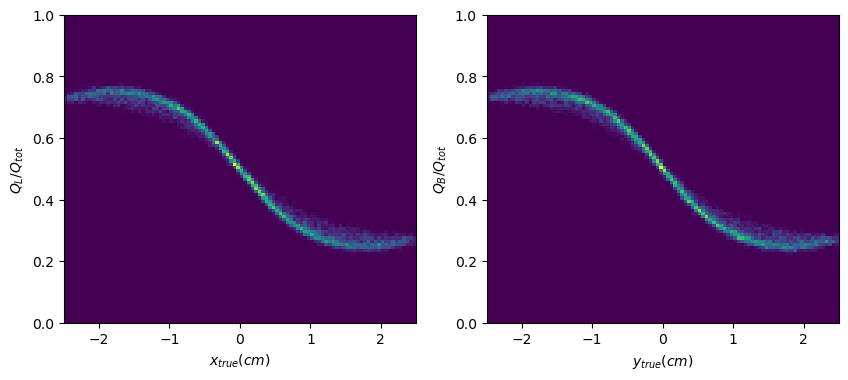

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(xp,q_lr,bins=(100,100), range=((-R,R),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(yp,q_tb,bins=(100,100), range=((-R,R),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')

.... and also $Q_{tot}$ as a function of radius.

Text(0, 0.5, '$Q_{tot}$')

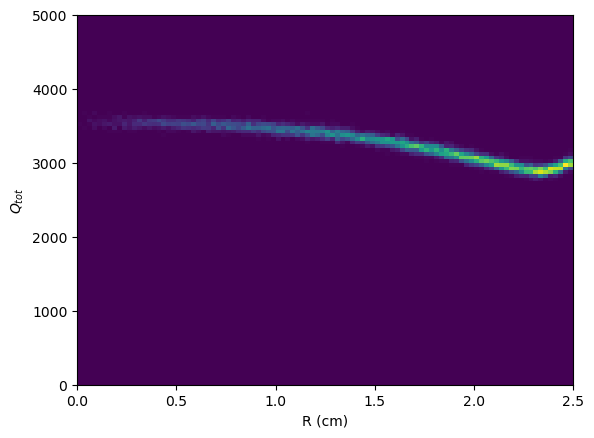

In [7]:
xp = np.array(xp)
yp = np.array(yp)
R = events.config['geometry']['radius']


q_tot = np.array(q_tot)
r2 = np.sqrt(xp**2+yp**2)
h=plt.hist2d(r2,q_tot,bins=100, range=((0,R),(0,5000)))
plt.xlabel('R (cm)')
plt.ylabel('$Q_{tot}$')

#### Event display

number of files:  1


AttributeError: 'Axes' object has no attribute 'x_label'

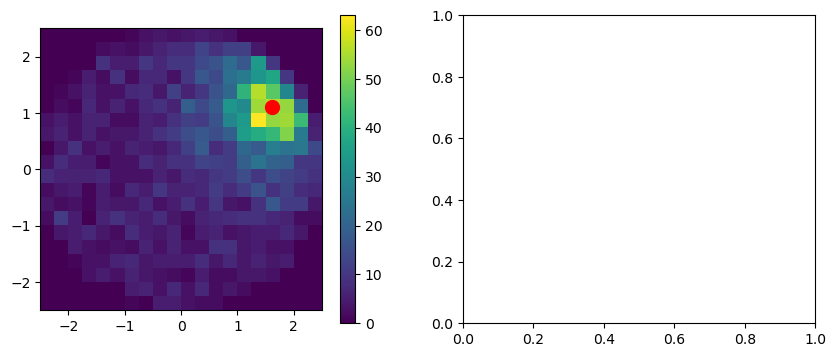

In [8]:
events = EventReader(files)

for ev in events:
    events.show_event(ev)
    response = input("Press Enter to continue to the next event or 'q' to quit...")

    if response.lower() == 'q':
        print("Quit the event display......")
        break
        
    clear_output(wait=True)

events.reset()

#### alternative is to write a loop over files every time you want to analyze something.... (may be a bit faster)


In [ ]:
%%time
# Get a list of all HDF5 files in the current directory
hdf5_files = glob.glob(data_dir+'*0001.hd5f')
print(hdf5_files)

# Read each file
xp = []
yp = []
q_tb = []
q_lr = []
q_tot = []

first_file = True
for hdf5_file in hdf5_files:
    with h5py.File(hdf5_file, 'r') as f:
        print(f"Reading file: {hdf5_file}")
        config = f.attrs['config']

        if first_file:
            display(config)
            first_file = False
        events_group = f['events']

        # Loop through all events in the events group
        for event_name, event_group in events_group.items():
            # Extract PMT and fine signals for each event
            x_true = event_group['true_position'][()]
            xp.append(x_true[0])
            yp.append(x_true[1])
            
            
            pmt = event_group['pmt_top'][()]
            qtot = float(np.sum(pmt))
            q_tb.append((pmt[0][0]+pmt[1][0])/qtot)
            q_lr.append((pmt[0][0]+pmt[0][1])/qtot)
            q_tot.append(qtot)
            
            fine_signal_top = event_group['fine_top'][()]
            pmt_signal_bot = event_group['pmt_bot'][()]
            fine_signal_bot = event_group['fine_bot'][()]
            
print('Done')